In [51]:
model_acc_df = pd.read_csv('indiv_team_accuracy.csv',
                 header=None,
                 names=["team", "MCC", "PR_AUC_1"]
                 )
model_acc_df

,team,MCC,PR_AUC_1
team1,0.5877,0.1898,0.2623
team2,0.7380,0.3240,0.3188


# MCC and PRAUC have same weights

In [5]:
import pandas as pd

# Load model predictions
team1_df = pd.read_csv("team1_probabilities.csv")
team2_df = pd.read_csv("team2_probabilities.csv")

# Load MCC and PR_AUC values
model_acc_df = pd.read_csv('indiv_team_accuracy.csv',
                 header=None,
                 names=["team", "MCC", "PR_AUC_1"]
                 )

# Extract MCC and PR-AUC for both teams
mcc_1, pr_auc_1 = model_acc_df.loc[model_acc_df['team'] == 'team1', ['MCC', 'PR_AUC_1']].values[0]
mcc_2, pr_auc_2 = model_acc_df.loc[model_acc_df['team'] == 'team2', ['MCC', 'PR_AUC_1']].values[0]

# Compute simple average weights
w1 = (mcc_1 + pr_auc_1) / (mcc_1 + pr_auc_1 + mcc_2 + pr_auc_2)
w2 = (mcc_2 + pr_auc_2) / (mcc_1 + pr_auc_1 + mcc_2 + pr_auc_2)

# Compute weighted probability for Class 1 (Spam)
team1_prob = team1_df["Prob (Class 1 - Spam)"]
team2_prob = team2_df["Prob (Class 1 - Spam)"]
final_prob = w1 * team1_prob + w2 * team2_prob

# Assign labels based on 0.5 threshold
team1_label = (team1_prob >= 0.5).astype(int)
team2_label = (team2_prob >= 0.5).astype(int)
predicted_label = (final_prob >= 0.5).astype(int)

# Create output dataframe
output_df = pd.DataFrame({
    "Actual Label": team1_df["Actual Label"],
    "team1_label": team1_label,
    "team2_label": team2_label,
    "predicted_label": predicted_label
})

# Save the result as CSV
output_df.to_csv("simple_final_predictions.csv", index=False)

print("Final predictions saved to final_predictions.csv")


<ipython-input-5-9f8676d3f453>:5: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  team2_df = pd.read_csv("team2_probabilities.csv")


Final predictions saved to final_predictions.csv


In [7]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, roc_auc_score, precision_recall_curve, auc
)

# Load the final predictions
output_df = pd.read_csv("simple_final_predictions.csv")

# Extract actual and predicted labels
y_true = output_df["Actual Label"]
y_pred = output_df["predicted_label"]

# Compute basic metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# Compute ROC-AUC for each class
roc_auc_0 = roc_auc_score(y_true, y_pred, average=None)
roc_auc_1 = roc_auc_score(y_true, y_pred)

# Compute PR-AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_true == 0, y_pred)
precision_1, recall_1, _ = precision_recall_curve(y_true == 1, y_pred)
pr_auc_0 = auc(recall_0, precision_0)
pr_auc_1 = auc(recall_1, precision_1)

# Save metrics to a DataFrame
metrics_df = pd.DataFrame([{
    "Accuracy": accuracy,
    "Balanced Accuracy": balanced_acc,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "MCC": mcc,
    "PR-AUC (Class 0 - Real)": pr_auc_0,
    "PR-AUC (Class 1 - Fake)": pr_auc_1,
    "ROC-AUC (Class 0 - Real)": roc_auc_0,
    "ROC-AUC (Class 1 - Fake)": roc_auc_1
}])

# Save to CSV
metrics_df.to_csv("simple_final_metrics.csv", index=False)

print("Metrics saved to final_metrics.csv ✅")


Metrics saved to final_metrics.csv ✅


# PR-AUC only

In [10]:
import pandas as pd
import numpy as np

# Load model probability outputs
team1_df = pd.read_csv("team1_probabilities.csv")
team2_df = pd.read_csv("team2_probabilities.csv")

# Load PR-AUC scores
model_acc_df = pd.read_csv('indiv_team_accuracy.csv',
                 header=None,
                 names=["team", "MCC", "PR_AUC_1"]
                 )
pr_auc_team1 = model_acc_df.loc[model_acc_df["team"] == "team1", "PR_AUC_1"].values[0]
pr_auc_team2 = model_acc_df.loc[model_acc_df["team"] == "team2", "PR_AUC_1"].values[0]

# Normalize PR-AUC weights so they sum to 1
total_pr_auc = pr_auc_team1 + pr_auc_team2
w1 = pr_auc_team1 / total_pr_auc
w2 = pr_auc_team2 / total_pr_auc

# Compute weighted probability for Class 1 (Fake)
weighted_prob_1 = (w1 * team1_df["Prob (Class 1 - Spam)"]) + (w2 * team2_df["Prob (Class 1 - Spam)"])

# Convert weighted probabilities into final labels (Threshold: 0.5)
final_pred_labels = (weighted_prob_1 >= 0.5).astype(int)

# Create final output DataFrame
final_df = pd.DataFrame({
    "Actual Label": team1_df["Actual Label"],  # Assumed same for both teams
    "team1_label": team1_df["Predicted Label"],
    "team2_label": team2_df["Predicted Label"],
    "predicted_label": final_pred_labels
})

# Save to CSV
final_df.to_csv("PR-AUC_final_predictions.csv", index=False)

print("Weighted predictions saved to final_predictions.csv ✅")


Weighted predictions saved to final_predictions.csv ✅


<ipython-input-10-1d8ab75ffad7>:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  team2_df = pd.read_csv("team2_probabilities.csv")


In [11]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, roc_auc_score, precision_recall_curve, auc
)

# Load the final predictions
output_df = pd.read_csv("PR-AUC_final_predictions.csv")

# Extract actual and predicted labels
y_true = output_df["Actual Label"]
y_pred = output_df["predicted_label"]

# Compute basic metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# Compute ROC-AUC for each class
roc_auc_0 = roc_auc_score(y_true, y_pred, average=None)
roc_auc_1 = roc_auc_score(y_true, y_pred)

# Compute PR-AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_true == 0, y_pred)
precision_1, recall_1, _ = precision_recall_curve(y_true == 1, y_pred)
pr_auc_0 = auc(recall_0, precision_0)
pr_auc_1 = auc(recall_1, precision_1)

# Save metrics to a DataFrame
metrics_df = pd.DataFrame([{
    "Accuracy": accuracy,
    "Balanced Accuracy": balanced_acc,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "MCC": mcc,
    "PR-AUC (Class 0 - Real)": pr_auc_0,
    "PR-AUC (Class 1 - Fake)": pr_auc_1,
    "ROC-AUC (Class 0 - Real)": roc_auc_0,
    "ROC-AUC (Class 1 - Fake)": roc_auc_1
}])

# Save to CSV
metrics_df.to_csv("PR-AUC_final_metrics.csv", index=False)

print("Metrics saved to final_metrics.csv ✅")


Metrics saved to final_metrics.csv ✅


# MCC Only

In [15]:
import pandas as pd
import numpy as np

# Load model probability outputs
team1_df = pd.read_csv("team1_probabilities.csv")
team2_df = pd.read_csv("team2_probabilities.csv")

# Load MCC scores
model_acc_df = pd.read_csv('indiv_team_accuracy.csv',
                 header=None,
                 names=["team", "MCC", "PR_AUC_1"]
                 )
mcc_team1 = model_acc_df.loc[model_acc_df["team"] == "team1", "MCC"].values[0]
mcc_team2 = model_acc_df.loc[model_acc_df["team"] == "team2", "MCC"].values[0]

# Compute weights using only MCC
weight_team1 = mcc_team1
weight_team2 = mcc_team2

# Normalize weights so they sum to 1
total_weight = weight_team1 + weight_team2
w1 = weight_team1 / total_weight
w2 = weight_team2 / total_weight

# Compute weighted probability for Class 1 (Fake)
weighted_prob_1 = (w1 * team1_df["Prob (Class 1 - Spam)"]) + (w2 * team2_df["Prob (Class 1 - Spam)"])

# Convert weighted probabilities into final labels (Threshold: 0.5)
final_pred_labels = (weighted_prob_1 >= 0.5).astype(int)

# Create final output DataFrame
final_df = pd.DataFrame({
    "Actual Label": team1_df["Actual Label"],  # Assumed same for both teams
    "team1_label": team1_df["Predicted Label"],
    "team2_label": team2_df["Predicted Label"],
    "predicted_label": final_pred_labels
})

# Save to CSV
final_df.to_csv("MCC_final_predictions_mcc.csv", index=False)

print("Weighted predictions based on MCC saved to final_predictions_mcc.csv ✅")


Weighted predictions based on MCC saved to final_predictions_mcc.csv ✅


<ipython-input-15-0e10d48d048d>:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  team2_df = pd.read_csv("team2_probabilities.csv")


In [16]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, roc_auc_score, precision_recall_curve, auc
)

# Load the final predictions
output_df = pd.read_csv("MCC_final_predictions_mcc.csv")

# Extract actual and predicted labels
y_true = output_df["Actual Label"]
y_pred = output_df["predicted_label"]

# Compute basic metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# Compute ROC-AUC for each class
roc_auc_0 = roc_auc_score(y_true, y_pred, average=None)
roc_auc_1 = roc_auc_score(y_true, y_pred)

# Compute PR-AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_true == 0, y_pred)
precision_1, recall_1, _ = precision_recall_curve(y_true == 1, y_pred)
pr_auc_0 = auc(recall_0, precision_0)
pr_auc_1 = auc(recall_1, precision_1)

# Save metrics to a DataFrame
metrics_df = pd.DataFrame([{
    "Accuracy": accuracy,
    "Balanced Accuracy": balanced_acc,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "MCC": mcc,
    "PR-AUC (Class 0 - Real)": pr_auc_0,
    "PR-AUC (Class 1 - Fake)": pr_auc_1,
    "ROC-AUC (Class 0 - Real)": roc_auc_0,
    "ROC-AUC (Class 1 - Fake)": roc_auc_1
}])

# Save to CSV
metrics_df.to_csv("MCC_final_metrics_mcc.csv", index=False)

print("Metrics for MCC-based weighted predictions saved to final_metrics_mcc.csv ✅")


Metrics for MCC-based weighted predictions saved to final_metrics_mcc.csv ✅


# 0.7 * PR-AUC + 0.3 * MCC

In [12]:
import pandas as pd
import numpy as np

# Load model probability outputs
team1_df = pd.read_csv("team1_probabilities.csv")
team2_df = pd.read_csv("team2_probabilities.csv")

# Load PR-AUC and MCC scores
model_acc_df = pd.read_csv('indiv_team_accuracy.csv',
                 header=None,
                 names=["team", "MCC", "PR_AUC_1"]
                 )
pr_auc_team1 = model_acc_df.loc[model_acc_df["team"] == "team1", "PR_AUC_1"].values[0]
pr_auc_team2 = model_acc_df.loc[model_acc_df["team"] == "team2", "PR_AUC_1"].values[0]
mcc_team1 = model_acc_df.loc[model_acc_df["team"] == "team1", "MCC"].values[0]
mcc_team2 = model_acc_df.loc[model_acc_df["team"] == "team2", "MCC"].values[0]

# Compute combined weights (70% PR-AUC, 30% MCC)
weight_team1 = (0.7 * pr_auc_team1) + (0.3 * mcc_team1)
weight_team2 = (0.7 * pr_auc_team2) + (0.3 * mcc_team2)

# Normalize weights so they sum to 1
total_weight = weight_team1 + weight_team2
w1 = weight_team1 / total_weight
w2 = weight_team2 / total_weight

# Compute weighted probability for Class 1 (Fake)
weighted_prob_1 = (w1 * team1_df["Prob (Class 1 - Spam)"]) + (w2 * team2_df["Prob (Class 1 - Spam)"])

# Convert weighted probabilities into final labels (Threshold: 0.5)
final_pred_labels = (weighted_prob_1 >= 0.5).astype(int)

# Create final output DataFrame
final_df = pd.DataFrame({
    "Actual Label": team1_df["Actual Label"],  # Assumed same for both teams
    "team1_label": team1_df["Predicted Label"],
    "team2_label": team2_df["Predicted Label"],
    "predicted_label": final_pred_labels
})

# Save to CSV
final_df.to_csv("0.7PR-AUC_final_predictions.csv", index=False)

print("Weighted predictions saved to final_predictions.csv ✅")


<ipython-input-12-c6f25c1e6ce2>:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  team2_df = pd.read_csv("team2_probabilities.csv")


Weighted predictions saved to final_predictions.csv ✅


In [14]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, roc_auc_score, precision_recall_curve, auc
)

# Load the final predictions
output_df = pd.read_csv("0.7PR-AUC_final_predictions.csv")

# Extract actual and predicted labels
y_true = output_df["Actual Label"]
y_pred = output_df["predicted_label"]

# Compute basic metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# Compute ROC-AUC for each class
roc_auc_0 = roc_auc_score(y_true, y_pred, average=None)
roc_auc_1 = roc_auc_score(y_true, y_pred)

# Compute PR-AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_true == 0, y_pred)
precision_1, recall_1, _ = precision_recall_curve(y_true == 1, y_pred)
pr_auc_0 = auc(recall_0, precision_0)
pr_auc_1 = auc(recall_1, precision_1)

# Save metrics to a DataFrame
metrics_df = pd.DataFrame([{
    "Accuracy": accuracy,
    "Balanced Accuracy": balanced_acc,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "MCC": mcc,
    "PR-AUC (Class 0 - Real)": pr_auc_0,
    "PR-AUC (Class 1 - Fake)": pr_auc_1,
    "ROC-AUC (Class 0 - Real)": roc_auc_0,
    "ROC-AUC (Class 1 - Fake)": roc_auc_1
}])

# Save to CSV
metrics_df.to_csv("0.7PR-AUC_final_metrics.csv", index=False)

print("Metrics saved to final_metrics.csv ✅")


Metrics saved to final_metrics.csv ✅


# 0.7 * MCC + 0.3 * PR-AUC

In [19]:
import pandas as pd
import numpy as np

# Load model probability outputs
team1_df = pd.read_csv("team1_probabilities.csv")
team2_df = pd.read_csv("team2_probabilities.csv")

# Load MCC and PR-AUC scores
model_acc_df = pd.read_csv('indiv_team_accuracy.csv',
                 header=None,
                 names=["team", "MCC", "PR_AUC_1"]
                 )
mcc_team1 = model_acc_df.loc[model_acc_df["team"] == "team1", "MCC"].values[0]
mcc_team2 = model_acc_df.loc[model_acc_df["team"] == "team2", "MCC"].values[0]
pr_auc_team1 = model_acc_df.loc[model_acc_df["team"] == "team1", "PR_AUC_1"].values[0]
pr_auc_team2 = model_acc_df.loc[model_acc_df["team"] == "team2", "PR_AUC_1"].values[0]

# Compute weighted score (70% MCC + 30% PR-AUC_1)
score_team1 = (0.7 * mcc_team1) + (0.3 * pr_auc_team1)
score_team2 = (0.7 * mcc_team2) + (0.3 * pr_auc_team2)

# Normalize weights so they sum to 1
total_score = score_team1 + score_team2
w1 = score_team1 / total_score
w2 = score_team2 / total_score

# Compute weighted probability for Class 1 (Fake)
weighted_prob_1 = (w1 * team1_df["Prob (Class 1 - Spam)"]) + (w2 * team2_df["Prob (Class 1 - Spam)"])

# Convert weighted probabilities into final labels (Threshold: 0.5)
final_pred_labels = (weighted_prob_1 >= 0.5).astype(int)

# Create final output DataFrame
final_df = pd.DataFrame({
    "Actual Label": team1_df["Actual Label"],  # Assumed same for both teams
    "team1_label": team1_df["Predicted Label"],
    "team2_label": team2_df["Predicted Label"],
    "predicted_label": final_pred_labels
})

# Save to CSV
final_df.to_csv("0.7MCC_final_predictions.csv", index=False)

print("Weighted predictions using 70% MCC + 30% PR-AUC saved to final_predictions_mcc_prauc.csv ✅")


<ipython-input-19-2a9de0268d29>:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  team2_df = pd.read_csv("team2_probabilities.csv")


Weighted predictions using 70% MCC + 30% PR-AUC saved to final_predictions_mcc_prauc.csv ✅


In [20]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score,
    matthews_corrcoef, roc_auc_score, precision_recall_curve, auc
)

# Load the final predictions
output_df = pd.read_csv("0.7MCC_final_predictions.csv")

# Extract actual and predicted labels
y_true = output_df["Actual Label"]
y_pred = output_df["predicted_label"]

# Compute basic metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# Compute ROC-AUC for each class
roc_auc_0 = roc_auc_score(y_true, y_pred, average=None)
roc_auc_1 = roc_auc_score(y_true, y_pred)

# Compute PR-AUC for each class
precision_0, recall_0, _ = precision_recall_curve(y_true == 0, y_pred)
precision_1, recall_1, _ = precision_recall_curve(y_true == 1, y_pred)
pr_auc_0 = auc(recall_0, precision_0)
pr_auc_1 = auc(recall_1, precision_1)

# Save metrics to a DataFrame
metrics_df = pd.DataFrame([{
    "Accuracy": accuracy,
    "Balanced Accuracy": balanced_acc,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "MCC": mcc,
    "PR-AUC (Class 0 - Real)": pr_auc_0,
    "PR-AUC (Class 1 - Fake)": pr_auc_1,
    "ROC-AUC (Class 0 - Real)": roc_auc_0,
    "ROC-AUC (Class 1 - Fake)": roc_auc_1
}])

# Save to CSV
metrics_df.to_csv("0.7MCC_final_metrics.csv", index=False)

print("Metrics for 70% MCC + 30% PR-AUC weighted predictions saved to final_metrics_mcc_prauc.csv ✅")


Metrics for 70% MCC + 30% PR-AUC weighted predictions saved to final_metrics_mcc_prauc.csv ✅


# Plot Graph

<Figure size 1200x600 with 0 Axes>

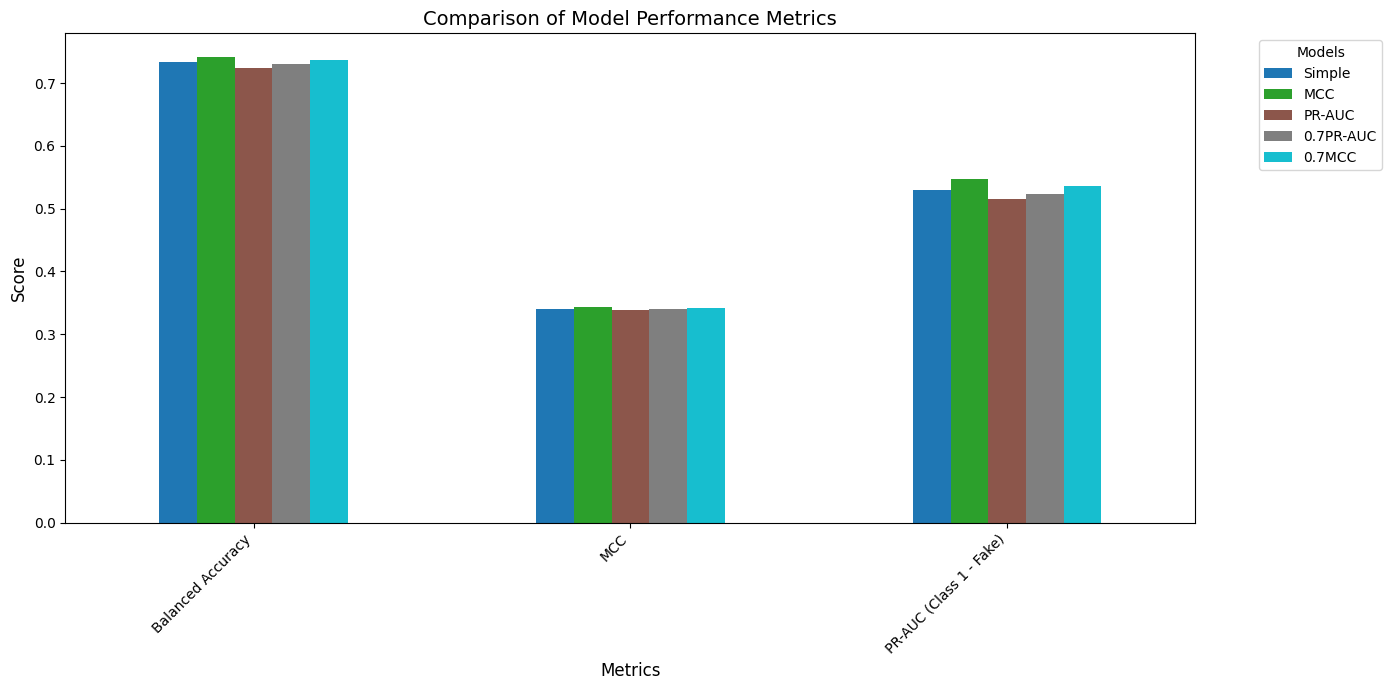

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the final accuracy CSV
df = pd.read_csv("weight_comparison.csv")

# Set model names as index
df.set_index("Model", inplace=True)

# Exclude ROC-AUC (Class 0) to keep the graph less cluttered (optional)
df = df.drop(columns=['Accuracy', 'Precision', 'Recall', 'F1-score',
           'PR-AUC (Class 0 - Real)', 'ROC-AUC (Class 0 - Real)',
           'ROC-AUC (Class 1 - Fake)'])

# Transpose the dataframe for better visualization
df_transposed = df.T

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
df_transposed.plot(kind="bar", figsize=(14, 7), colormap="tab10")

# Customize the plot
plt.title("Comparison of Model Performance Metrics", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.tight_layout()
plt.show()


# Best weight to use is MCC
compare combined results with individual team results

<ipython-input-48-8f9d24d07bd6>:42: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


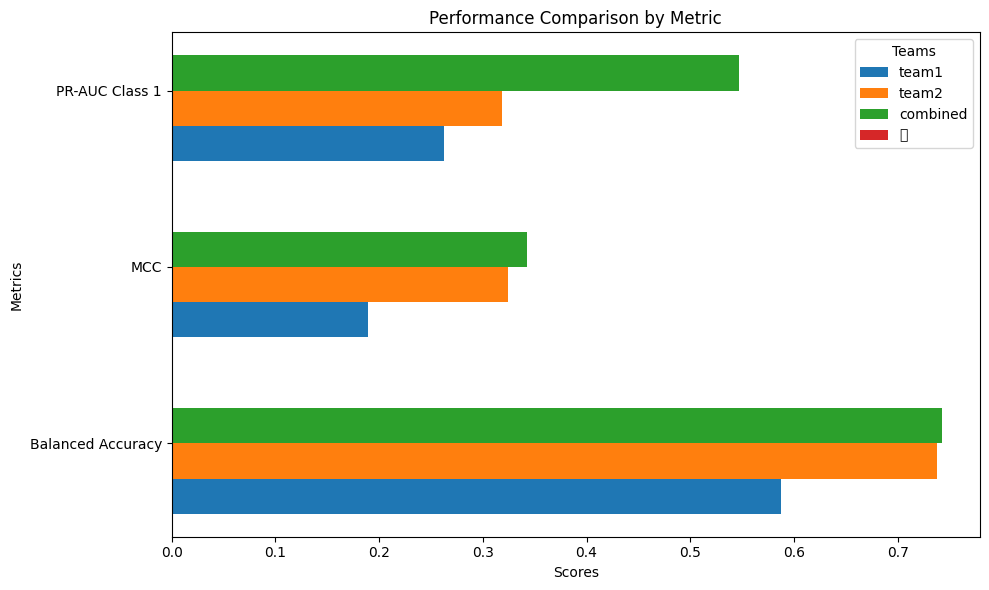

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv('team_model_comparison.csv')

# Define the metrics and teams
metrics = ['Balanced Accuracy', 'MCC', 'PR-AUC Class 1']
# Drop rows with NaN values in the 'team' column
df = df.dropna(subset=['team'])
teams = df['team'].astype(str)  # Convert team names to strings

# Set the bar height and positions
bar_width = 0.2
index = np.arange(len(metrics))

# Create a figure and axes
plt.figure(figsize=(10, 6))

# Plot the bars for each team (horizontal bars)
for i, team in enumerate(teams):
    plt.barh(index + i * bar_width, df.loc[df['team'] == team, metrics].values.flatten(), bar_width, label=team)

# Add labels and title
plt.xlabel('Scores')
plt.ylabel('Metrics')
plt.title('Performance Comparison by Metric')

# Set y-ticks to show the metrics
plt.yticks(index + bar_width * (len(teams) - 1) / 2, metrics)

# Show the legend, customizing handles to remove red
handles, labels = plt.gca().get_legend_handles_labels()
# Assuming 'team1' is the red legend entry
# Remove the handle and label corresponding to 'team1'
handles = [h for h, l in zip(handles, labels) if l != '[]']
labels = [l for l in labels if l != '[]']
plt.legend(handles, labels, title='Teams')

# Display the graph
plt.tight_layout()
plt.show()